In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy import optimize
import os

import plotly.graph_objects as go
import numpy as np
import sys
import os
from matplotlib import pyplot as plt              # A collection of modules. Needed here to display images and graphs.
from matplotlib.colors import LogNorm             # Machinery for LogNorm scaling of intensities.
from matplotlib.colors import SymLogNorm          # Machinery for SymLogNorm scaling of intensities.
from matplotlib.colors import PowerNorm           # Machinery for LogNorm (e.g., square root) scaling of intensities.

from astropy.io import fits                       # Need this if you want to use astropy.io io objects.
from astropy.stats import mad_std                 # The median absolute deviation, a more robust estimator than std.


In [2]:
ur12 = '/Users/nathaliechicoine/cool_lamps/sims1/z0.2/'
ur16 = '/Users/nathaliechicoine/cool_lamps/sims1/z0.6/'
os.listdir(ur16)

['s5__demo.fits',
 's8__demo.fits',
 's0__demo.fits',
 's7__demo.fits',
 's2__demo.fits',
 's1__demo.fits',
 's4__demo.fits',
 's9__demo.fits',
 's3__demo.fits',
 's6__demo.fits']

In [3]:
gband = fits.getdata(ur16 + os.listdir(ur16)[2])[0]
rband = fits.getdata(ur16 + os.listdir(ur16)[2])[1]
zband = fits.getdata(ur16 + os.listdir(ur16)[2])[2]
gband = np.array(gband)
rband = np.array(rband)
zband = np.array(zband)

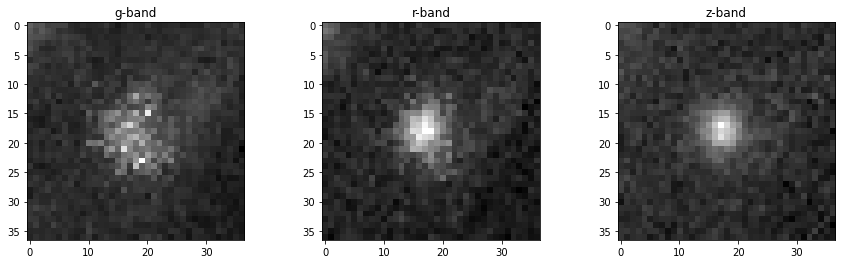

In [4]:
grzband = [gband, rband, zband]
grz = ['g-band', 'r-band', 'z-band']
norm = ImageNormalize(stretch = LogStretch())

f, axarr = plt.subplots(1, 3, figsize=(15,4))
for i, image in enumerate(grzband):
    axarr[i].imshow(image, cmap = 'gray')
    axarr[i].set_title(grz[i])
    

In [5]:
# crop the image
# select a region that contains the central lens galaxy
length = len(zband)
xpos, ypos = length/2, length/2
# select a square region to contain this lens galaxy
size = 10
lens_cropped_z = zband[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]
lens_cropped_g = gband[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]
lens_cropped_r = rband[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]

cropped_grz = [lens_cropped_g, lens_cropped_r, lens_cropped_z]

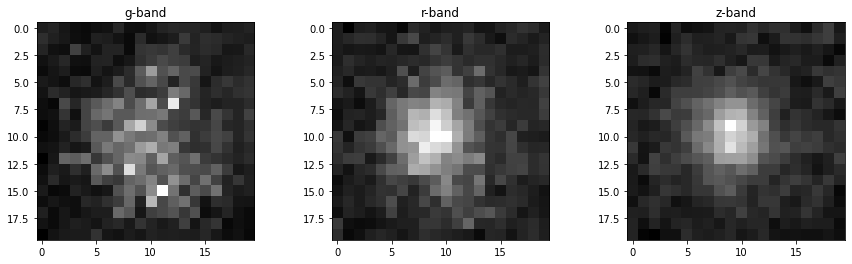

In [6]:
f, axarr = plt.subplots(1, 3, figsize=(15,4))
for i, image in enumerate(cropped_grz):
    axarr[i].imshow(image, cmap = 'gray')
    axarr[i].set_title(grz[i])

In [7]:
# set some priors on the scaling factor
f_scl = np.sum(lens_cropped_g) / np.sum(lens_cropped_z)
print(f_scl)
f_min = 0.5 * f_scl
print(f_min)
f_max = 1.5 * f_scl
print(f_max)

0.27864512416772386
0.13932256208386193
0.41796768625158576


In [8]:
def quickpic4(image,titlestring='',madfactor=(3.,10.),mask=([0],[0]),mask2=([0],[0]) ,csize=100,edgecolor='r',\
               edgecolor2='b', figlims=(10,10), ilims=(0.,0.), cmap='gray', plotmasks=False):
    '''
    A simple image display tool with initial autoscaling based on image median and mad_std.
    It also includes the option to plot circles around positions defined in one or two image masks.
    Arguments:
        image:       A 2D image.
        titlestring: A text string for the figure title. Default is empty string.
        madfactor:   A tuple with multipliers for mad_std to subtract or add to median to get vmin and vmax for imshow.
        mask:        A tuple of ndarrays with lists of the row and column coordinates of the circles to plot.
        mask2:       Another mask array for a second set of circles with twice the radius and different color.
        csize:       Sets size of circles for mask positions. Circles for mask2 positions are two times larger.
        edgecolor:   The color for the mask circles.
        edgecolor2:  The color for the mask2 circles.
        figlims:     Tuple to determine figsize.
        cmap:        Color map. Default = 'gray'
        plotmasks:   If True, plot circles around mask positions. Default = False.
    Author(s) = Al Harper
    Created: 190818.
    Modified: 210705, 210728, 210805.
    Version = 1.1
    '''

    pic = image.copy()
    rows, cols = pic.shape
    med, mad = np.nanmedian(pic), mad_std(pic,ignore_nan=True)
    #vmn, vmx = ilims
    if ilims == (0.,0.):
        vmn, vmx = med - mad * madfactor[0], med + mad * madfactor[1]
    else:
        vmn, vmx = ilims
    plt.figure(figsize = (figlims))
    plt.title(titlestring)
    plt.imshow(pic, cmap, interpolation='nearest', vmin = vmn, vmax = vmx)
    plt.colorbar(orientation = 'vertical',shrink = 0.8)
    if plotmasks == True:
        for i in mask:
            plt.scatter(mask[1],mask[0],s=csize, facecolors='none', edgecolors=edgecolor)
        for i in mask2:
            plt.scatter(mask2[1],mask2[0],s=2*csize, facecolors='none', edgecolors=edgecolor2)

2D Gaussian-like array: [[1.91516960e-174 4.03520165e-157 1.01081658e-141 3.01043034e-128
  1.06594284e-116 4.48733368e-107 2.24590779e-099 1.33642500e-093
  9.45466986e-090 7.95238245e-088 7.95238245e-088 9.45466986e-090
  1.33642500e-093 2.24590779e-099 4.48733368e-107 1.06594284e-116
  3.01043034e-128 1.01081658e-141 4.03520165e-157 1.91516960e-174]
 [4.03520165e-157 8.50204201e-140 2.12975850e-124 6.34288133e-111
  2.24590779e-099 9.45466986e-090 4.73205655e-082 2.81580512e-076
  1.99206898e-072 1.67554178e-070 1.67554178e-070 1.99206898e-072
  2.81580512e-076 4.73205655e-082 9.45466986e-090 2.24590779e-099
  6.34288133e-111 2.12975850e-124 8.50204201e-140 4.03520165e-157]
 [1.01081658e-141 2.12975850e-124 5.33503749e-109 1.58888952e-095
  5.62599105e-084 2.36839144e-074 1.18537849e-066 7.05358182e-061
  4.99012572e-057 4.19722621e-055 4.19722621e-055 4.99012572e-057
  7.05358182e-061 1.18537849e-066 2.36839144e-074 5.62599105e-084
  1.58888952e-095 5.33503749e-109 2.12975850e-124 

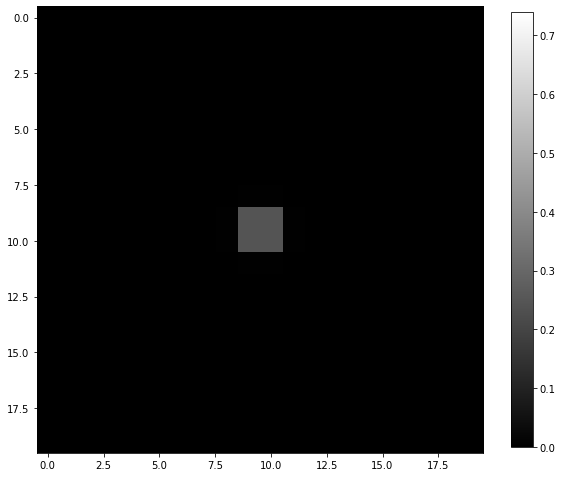

In [9]:
x, y = np.meshgrid(np.linspace(-1,1,20), np.linspace(-1,1,20))
d = np.sqrt(x*x + y*y)
sigma, mu = 0.05, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
g1 = g/np.sum(g)
print("2D Gaussian-like array:", g, np.sum(g1))
quickpic4(g1, ilims=(0,1/np.sum(g)))

In [10]:
"""def convolve_rescale_star_gz(x):
    
    Convolve the original image with a Gaussian kernel, then rescale it
    ----------
    Input:
        x: 1d list of length 2
           x[0]: the width of Gaussian kernel
           x[1]: the rescaling factor
    ----------
    Output:
        diffsum: float
                 the sum of the the residual pixel values between convolved, rescaled z-band image
                 and original g-band image
   
    # first smooth the image
    img = star_cropped_z
    # make the sure kernel has a positive size:
    if x[0] > 0:
        kernel = Gaussian2DKernel(x_stddev=x[0])
    else:
        kernel = Gaussian2DKernel(x_stddev=2)
    z_conv = convolve(img, kernel)
    # then rescale it
    z_final = z_conv * x[1]
    # finally subtract it from g-band image
    diff = (z_final - star_cropped_g)**2
    diffsum = np.sqrt(np.sum(diff))
    return diffsum"""

'def convolve_rescale_star_gz(x):\n    \n    Convolve the original image with a Gaussian kernel, then rescale it\n    ----------\n    Input:\n        x: 1d list of length 2\n           x[0]: the width of Gaussian kernel\n           x[1]: the rescaling factor\n    ----------\n    Output:\n        diffsum: float\n                 the sum of the the residual pixel values between convolved, rescaled z-band image\n                 and original g-band image\n   \n    # first smooth the image\n    img = star_cropped_z\n    # make the sure kernel has a positive size:\n    if x[0] > 0:\n        kernel = Gaussian2DKernel(x_stddev=x[0])\n    else:\n        kernel = Gaussian2DKernel(x_stddev=2)\n    z_conv = convolve(img, kernel)\n    # then rescale it\n    z_final = z_conv * x[1]\n    # finally subtract it from g-band image\n    diff = (z_final - star_cropped_g)**2\n    diffsum = np.sqrt(np.sum(diff))\n    return diffsum'

In [11]:
# use Nelder-Mead to find the minimization; x0 is an initial guess: (width, scaling factor)
#res_gz_star = scipy.optimize.minimize(convolve_rescale_star_gz, x0=[5, 0.3], method='Nelder-Mead')
#width_gz, f_rescale_gz_star = res_gz_star.x[0], res_gz_star.x[1]
#print(width_gz, f_rescale_gz_star)

In [12]:
"""def convolve_rescale_lens_gz(x, lens_cropped_g, lens_cropped_z):
    
    Similar to the previous function, but instead of using the portion of the image that contains the star,
    we use the central portion that contains the lens
    We also use the width of the Gaussian kernel derived in the previous step
    We only need to solve for the rescaling factor here; x is one-dimensional
    
    # first smooth the image
    img = lens_cropped_z
    # use the kernel whose width we derived earlier
    kernel = Gaussian2DKernel(x_stddev=width_gz)
    z_conv = convolve(img, kernel)
    # then rescale it
    z_final = z_conv * x
    # finally subtract it from g-band image
    lens_cropped_g_sort = np.array(np.sort(lens_cropped_g))
    counter = 0
    for i in range(3):
        if counter>0:
            lens_cropped_g_sort[((counter+1)*(-10)):, ((counter+1)*(-10)):] = 0
            counter+=1
        else: 
            lens_cropped_g_sort[-10:, -10:] = 0
            counter+=1
        print(x)
        diff = ((z_final - lens_cropped_g_sort)**2)
        diffsum = np.sqrt(np.sum(diff))
    return diffsum"""

'def convolve_rescale_lens_gz(x, lens_cropped_g, lens_cropped_z):\n    \n    Similar to the previous function, but instead of using the portion of the image that contains the star,\n    we use the central portion that contains the lens\n    We also use the width of the Gaussian kernel derived in the previous step\n    We only need to solve for the rescaling factor here; x is one-dimensional\n    \n    # first smooth the image\n    img = lens_cropped_z\n    # use the kernel whose width we derived earlier\n    kernel = Gaussian2DKernel(x_stddev=width_gz)\n    z_conv = convolve(img, kernel)\n    # then rescale it\n    z_final = z_conv * x\n    # finally subtract it from g-band image\n    lens_cropped_g_sort = np.array(np.sort(lens_cropped_g))\n    counter = 0\n    for i in range(3):\n        if counter>0:\n            lens_cropped_g_sort[((counter+1)*(-10)):, ((counter+1)*(-10)):] = 0\n            counter+=1\n        else: \n            lens_cropped_g_sort[-10:, -10:] = 0\n            cou

In [14]:
# use Nelder-Mead to find the minimization; x0 is an initial guess: scaling factor
#res_gz_scale = scipy.optimize.minimize(convolve_rescale_lens_gz, x0=4, args = (lens_cropped_g, lens_cropped_z), method='Nelder-Mead')
#f_gz_rescale = res_gz_scale.x[0]
# and this will be the final answer!
#print(width_gz, f_gz_rescale)

In [27]:
# beware! this code goes on forever
def convolve_rescale_psf_lens(x, f_scl, f_min, f_max, gimg, zimg):
    """
    We solve for the rescaling factor and psf together, using iteration
    """
    # finally subtract it from g-band image
    gimg_sort = np.array(np.sort(gimg))
    counter = 0
    
    for i in range(3):
        if counter>0:
            gimg_sort[((counter+1)*(-10)):, ((counter+1)*(-10)):] == 0            
            counter+=1
        else: 
            gimg_sort[-10:, -10:] == 0
            counter+=1
    kernel = Gaussian2DKernel(x_stddev=x[0])
    z_conv = convolve(zimg, kernel)
    if x[1] >= f_max:
        x[1] = f_max
    elif x[1] <= f_min:
        x[1] = f_min
    z_final = z_conv*x[1]
    print(x[0], x[1])
    diff = (((z_final - gimg_sort)* g1)**2)
    diffsum = np.sqrt((np.sum(diff)/np.sum(g1**2)))
    print(diffsum)
    return diffsum

In [28]:
# use Nelder-Mead to find the minimization; x0 is an initial guess: scaling factor
#f_scl = np.sum(lens_cropped_g) / np.sum(lens_cropped_z)
#f_min = 0.2 * f_scl
#f_max = 5. * f_scl
#print(f_min)
#print(f_max)
res_psf = optimize.minimize(convolve_rescale_psf_lens, x0=[4.,0.3], args = (f_scl, f_min, f_max, lens_cropped_g, lens_cropped_z),
                        method='Nelder-Mead')
width, f_rescale_psf = res_psf.x[0], res_psf.x[1]
print(width, f_rescale_psf)


4.0 0.3
0.009557508574856094
4.2 0.3
0.00841682897943367
4.0 0.315
0.010776250036999913
4.199999999999999 0.285
0.007261261959914111
4.299999999999999 0.2699999999999999
0.005629981609627194
4.5 0.26999999999999985
0.004717141479480413
4.75 0.2549999999999998
0.0027236305852923154
4.849999999999999 0.2249999999999997
0.0012385977966793008
5.174999999999999 0.18749999999999956
0.0035997818253983163
5.299999999999999 0.20999999999999958
0.002640727705689973
5.399999999999999 0.1799999999999995
0.004561685096108127
4.9125 0.2362499999999997
0.001356269280272019
4.4625 0.2512499999999998
0.003569550981468953
5.090624999999999 0.22031249999999963
0.0016382518953046194
4.671875 0.24093749999999975
0.002150031478888094
4.9859374999999995 0.22546874999999966
0.0013034182410792763
4.923437499999999 0.21421874999999965
0.0015551303914063768
4.915234374999999 0.2307421874999997
0.0012514848688395409
4.779296874999999 0.23027343749999973
0.0013863222091976607
4.934277343749999 0.22666992187499968


In [29]:
res_scale = optimize.minimize(convolve_rescale_psf_lens, x0=[width, 0.3], args = (f_scl, f_min, f_max, lens_cropped_g, lens_cropped_z),
                        method='Nelder-Mead')
width, f_rescale = res_scale.x[0], res_scale.x[1]
# and this will be the final answer!
print(width, f_rescale)

3.949192470265677 0.3
0.009859759023301261
4.146652093778961 0.3
0.008713052869424304
3.949192470265677 0.315
0.011094166885498418
4.146652093778961 0.285
0.0075416540012956555
4.245381905535602 0.2699999999999999
0.005890680212195753
4.442841529048886 0.26999999999999985
0.004970762457501127
4.689666058440491 0.2549999999999998
0.0029415595150727157
4.788395870197132 0.2249999999999997
0.0012598029778135504
5.109267758406217 0.18749999999999956
0.003438238386994818
5.23268002310202 0.20999999999999958
0.0024743882424121824
5.331409834858661 0.1799999999999995
0.004405790583607573
4.850102002545033 0.2362499999999997
0.0014609262053585236
4.405817849640144 0.2512499999999998
0.0038002503834860435
5.025964479736551 0.22031249999999963
0.0015129851819011596
4.612533393005613 0.24093749999999975
0.0023433695487184666
4.9226067080538165 0.22546874999999966
0.0012539397469129886
4.860900575705915 0.21421874999999965
0.0014419881992336367
4.858200932415695 0.21972656249999967
0.0012899711724

In [30]:
# convert sigma to PSF: PSF = 2.355 * sigma
psf = width * 2.355
print('PSF = {:2f}; scaling factor = {:2f}'.format(psf, f_rescale))

PSF = 9.300540; scaling factor = 0.181971


In [31]:
kernel = Gaussian2DKernel(x_stddev=width)
z_conv = convolve(zband, kernel)
zband_final = z_conv *f_rescale
gz = gband-zband_final

In [32]:
# convert the image to a fits file
hdu = fits.PrimaryHDU(gz)
hdul = fits.HDUList([hdu])
if os.path.exists('gz_2.fits'): # if the file already exists, overwrite it
    os.remove('gz_2.fits')
    hdul.writeto('gz_2.fits')
else:
    hdul.writeto('gz_2.fits')

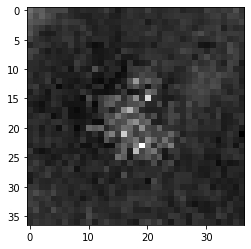

In [33]:
plt.imshow(gz, cmap = 'gray')

In [ ]:
# use Nelder-Mead to find the minimization; x0 is an initial guess: scaling factor
res = optimize.minimize(convolve_rescale_lens, x0=[2,2], args = (rband, zband),
                        method='Nelder-Mead')
width, f_rescale = res.x[0], res.x[1]
# and this will be the final answer!
print(width, f_rescale)

kernel = Gaussian2DKernel(x_stddev=width)
z_conv = convolve(zband, kernel)
zband_final = z_conv *f_rescale
rz = rband-zband_final

In [ ]:
plt.imshow(rz, cmap = 'gray')